In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
import matplotlib.gridspec as gridspec
from datetime import timedelta

import seaborn as sns
from pprint import pprint

from scipy.ndimage import gaussian_filter
from skimage import feature

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import tree
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from sklearn.neural_network import MLPRegressor

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
df_raw = pd.read_csv('./data/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw.copy()
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df = df.set_index('Date', verify_integrity=True)
df

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2002-06-03,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-04,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-05,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-06,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2002-06-07,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31
...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.60
2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.60
2020-06-28,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.60


<AxesSubplot:>

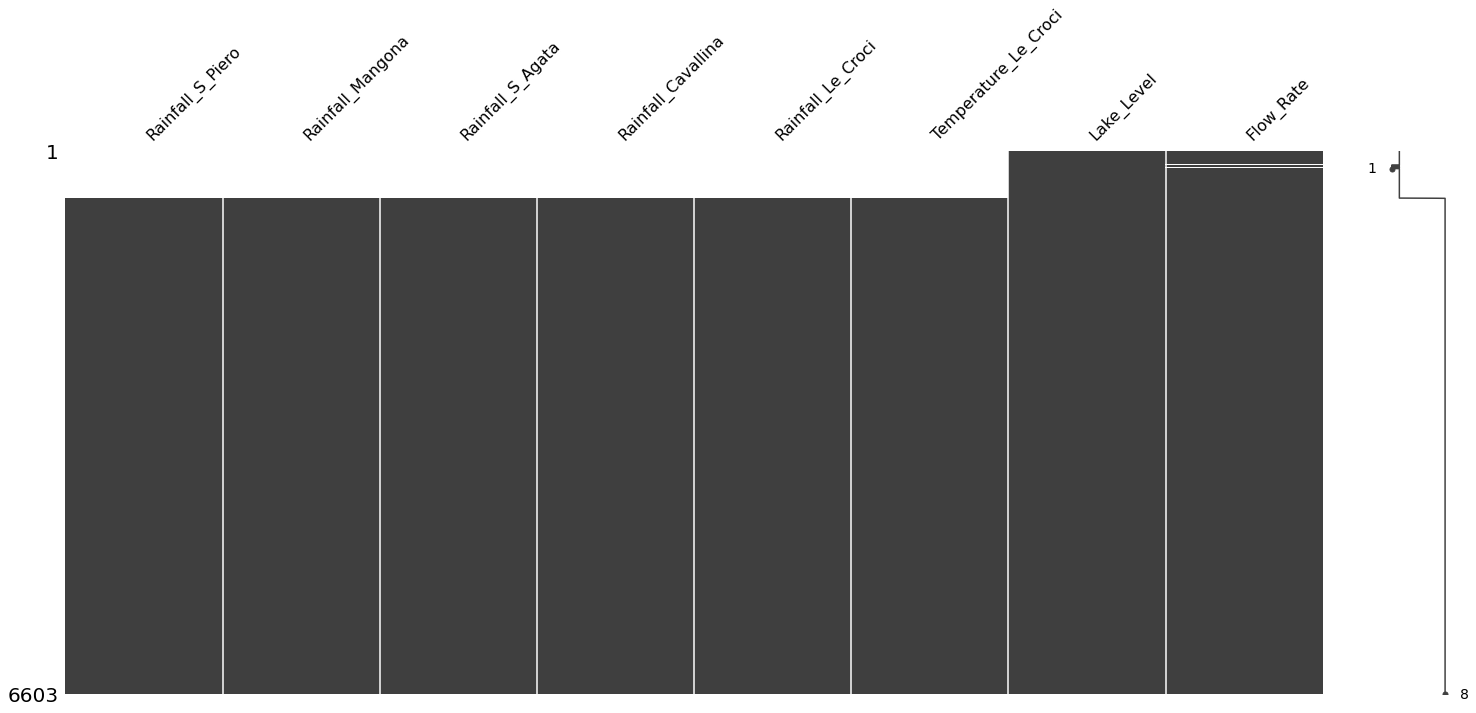

In [4]:
msno.matrix(df)

<AxesSubplot:>

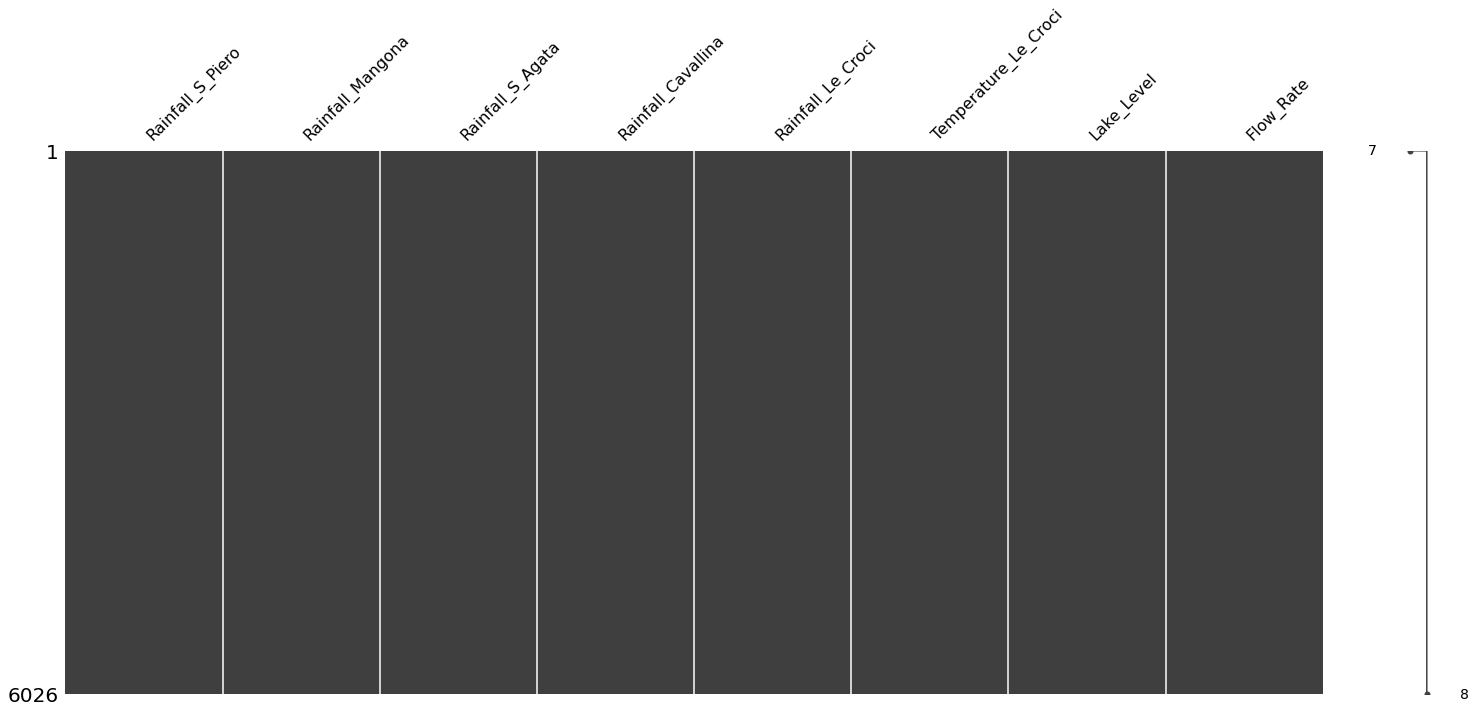

In [5]:
# we cut out top rows with most missing values
df = df[df.index >= pd.to_datetime('2004-01-01')]
msno.matrix(df)

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Rainfall_S_Piero,1.000000,0.867117,0.897863,0.908543,0.910068,-0.133295,-0.034152,0.142241
Rainfall_Mangona,0.867117,1.000000,0.865833,0.873150,0.863780,-0.134986,-0.032264,0.166216
Rainfall_S_Agata,0.897863,0.865833,1.000000,0.887618,0.880652,-0.124250,-0.032259,0.158884
Rainfall_Cavallina,0.908543,0.873150,0.887618,1.000000,0.922999,-0.128926,-0.033957,0.172795
Rainfall_Le_Croci,0.910068,0.863780,0.880652,0.922999,1.000000,-0.139045,-0.024512,0.187022
Temperature_Le_Croci,-0.133295,-0.134986,-0.124250,-0.128926,-0.139045,1.000000,0.063569,-0.195136
Lake_Level,-0.034152,-0.032264,-0.032259,-0.033957,-0.024512,0.063569,1.000000,0.298746
Flow_Rate,0.142241,0.166216,0.158884,0.172795,0.187022,-0.195136,0.298746,1.000000


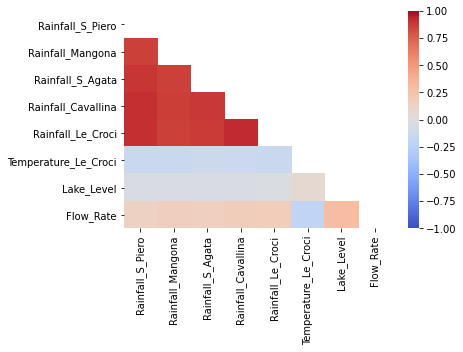

In [6]:
def correlation_matrix(df):
    corr = df.corr(method='pearson')
    sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='coolwarm')
    return corr

correlation_matrix(df)

<AxesSubplot:>

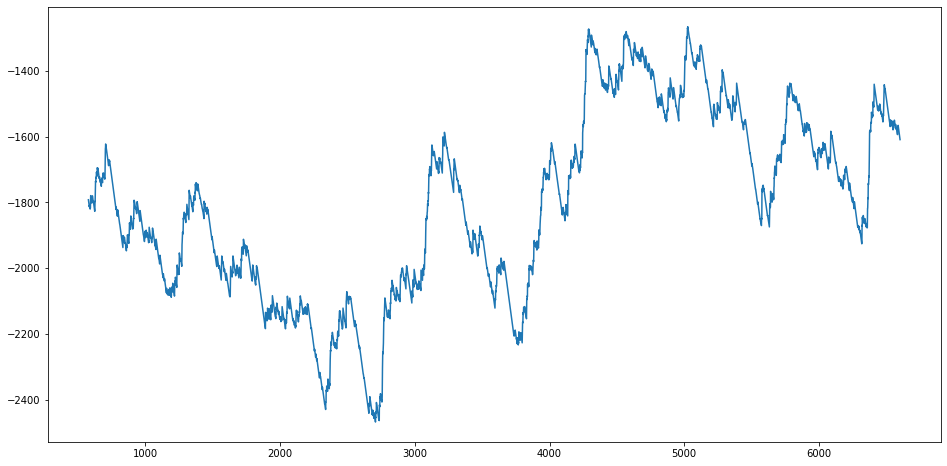

In [7]:
dfr = df_raw.copy()

dfr.shape

water_ground_penetration = 3.1

dfr['Rainfall_Ground_Penetration'] = water_ground_penetration
dfr['Rainfall_Ground_Penetration'] = dfr['Rainfall_Ground_Penetration'].cumsum()

dfr['Rainfall_Le_Croci2'] = dfr['Rainfall_Le_Croci'].cumsum() - dfr['Rainfall_Ground_Penetration']

dfr['Rainfall_Le_Croci2'].plot(figsize=(16, 8))

# correlation_matrix(dfr)

In [8]:

df = df.drop(['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci'], axis=1, errors='ignore')
df

,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,
2004-01-01,NaN,251.14,0.5
2004-01-02,6.50,251.21,0.5
2004-01-03,4.45,251.28,0.5
2004-01-04,2.00,251.35,0.5
2004-01-05,0.90,251.37,0.5
...,...,...,...
2020-06-26,22.50,250.85,0.6
2020-06-27,23.40,250.84,0.6
2020-06-28,21.50,250.83,0.6


<AxesSubplot:xlabel='Date'>

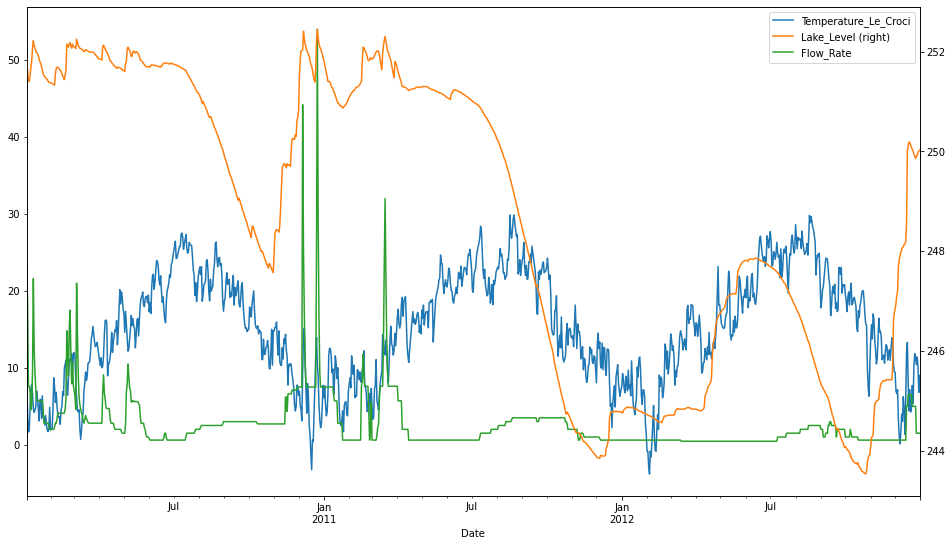

In [9]:
df[
    (df.index > pd.to_datetime('2010-01-01')) &
    (df.index < pd.to_datetime('2013-01-01'))
].plot(secondary_y=['Lake_Level'], figsize=(16, 9))

<AxesSubplot:xlabel='Date'>

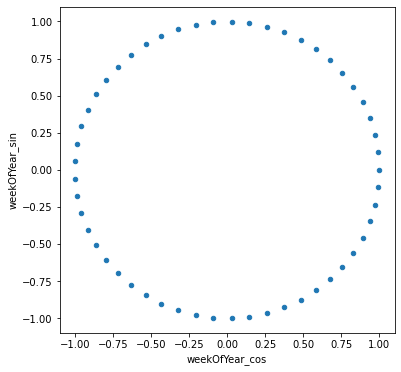

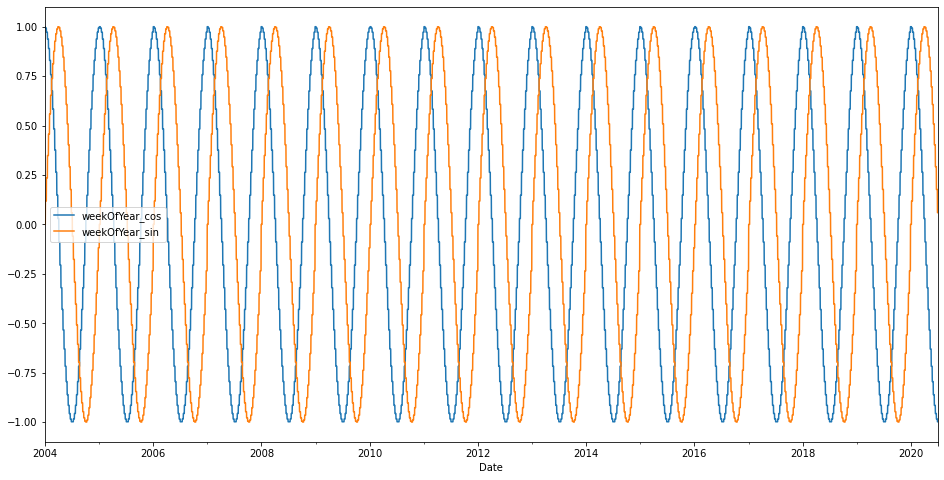

In [10]:
# TIME BY DAYS OF YEAR
# df['day_sin'] = np.sin(df.index.dayofyear - 1) * (2. * np.pi / 365)
# df['day_cos'] = np.cos(df.index.dayofyear - 1) * (2. * np.pi / 365)
# df.groupby(['day_cos', 'day_sin']).size().reset_index().plot(x='day_cos', y='day_sin', kind='scatter', figsize=(6, 6));


# TIME BY WEEKS IN YEAR
weeksInYear = len(pd.to_datetime(df.index).isocalendar().week.unique())

df['weekOfYear_cos'] = np.cos((pd.to_datetime(df.index).isocalendar().week - 1) * (2. * np.pi / weeksInYear))
df['weekOfYear_sin'] = np.sin((pd.to_datetime(df.index).isocalendar().week - 1) * (2. * np.pi / weeksInYear))

df.groupby(['weekOfYear_cos', 'weekOfYear_sin']).size().reset_index().plot(x='weekOfYear_cos', y='weekOfYear_sin', kind='scatter', figsize=(6, 6));
df[['weekOfYear_cos', 'weekOfYear_sin']].plot(figsize=(16, 8))

# TIME BY MONTHS
# df['month_sin'] = np.sin((pd.to_datetime(df.index).month - 1) * (2. * np.pi / 12))
# df['month_cos'] = np.cos((pd.to_datetime(df.index).month - 1) * (2. * np.pi / 12))
# df.groupby(['month_cos', 'month_sin']).size().reset_index().plot(x='month_cos', y='month_sin', kind='scatter', figsize=(4, 4))

In [11]:
# Lake_level is givein relative to sea elevation of the lake which 251m and lake depth is on average 31m
# For easier result interpretation we transofrm them to only lake depth
df['Lake_Level'] -= (252 - 31)

In [12]:
df['Temperature_Le_Croci'] = df['Temperature_Le_Croci'] / df['Temperature_Le_Croci'].max()

,Temperature_Le_Croci,Lake_Level,Flow_Rate,weekOfYear_cos,weekOfYear_sin
Temperature_Le_Croci,1.000000,0.063569,-0.195136,-0.868785,-0.238613
Lake_Level,0.063569,1.000000,0.298746,-0.263252,0.624531
Flow_Rate,-0.195136,0.298746,1.000000,0.212675,0.120541
weekOfYear_cos,-0.868785,-0.263252,0.212675,1.000000,0.004215
weekOfYear_sin,-0.238613,0.624531,0.120541,0.004215,1.000000


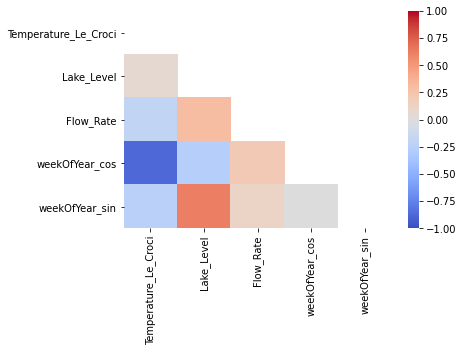

In [13]:
correlation_matrix(df)

In [14]:
# Spliting data for models
split = df[df.index >= pd.to_datetime('2016-01-01')].index[0]

d = df.dropna()
d = d.drop(['Flow_Rate'], axis=1) # Flow_Rate is another target variable

lrn = d.drop(['Lake_Level'], axis=1)
tgt = d['Lake_Level']

lrn_input = lrn[lrn.index < split]
lrn_output = tgt[tgt.index < split]

tgt_input = lrn[lrn.index >= split]
tgt_output = tgt[tgt.index >= split]

def run_model(model, learn_input, learn_ouput, target_input, target_output):
    model.fit(learn_input, learn_ouput)
    return pd.DataFrame({ 'Predictions': model.predict(target_input), 'Lake_Level': target_output })

def evaluate_ae(result, column='Predictions'):
    result = result.dropna()
    mae = mean_absolute_error(result[column], result['Lake_Level'])
    rmae = mean_squared_error(result[column], result['Lake_Level'])
    print('   MAE: {}'.format(mae))
    print('   RMAE: {}'.format(rmae))
    return (mae, rmae)

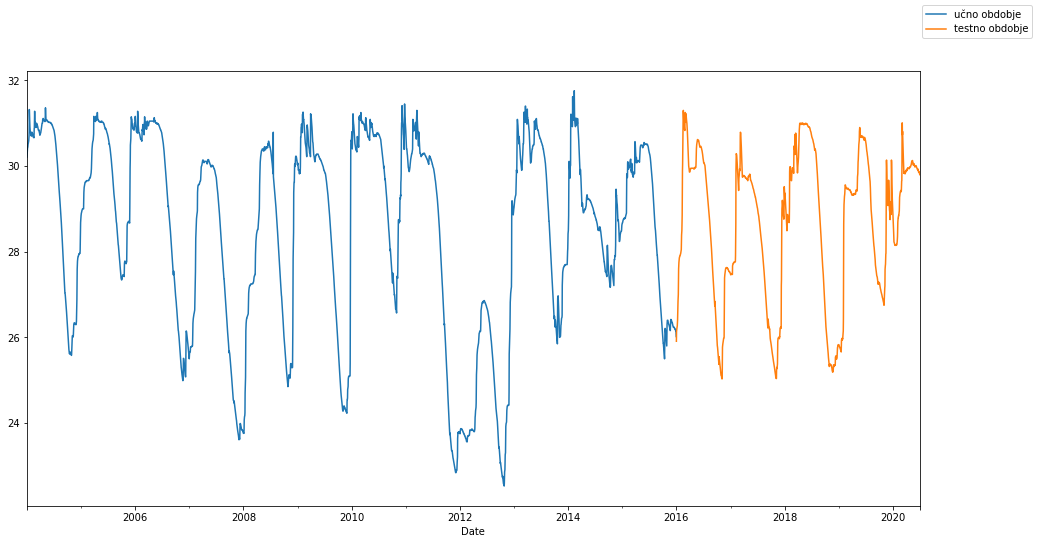

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

lrn_output.plot(ax=ax, label='učno obdobje')
tgt_output.plot(ax=ax, label='testno obdobje')

fig.legend()

   MAE: 0.9443061054897851
   RMAE: 1.8378523335754395


<AxesSubplot:title={'center':'Decision tree'}, xlabel='Date'>

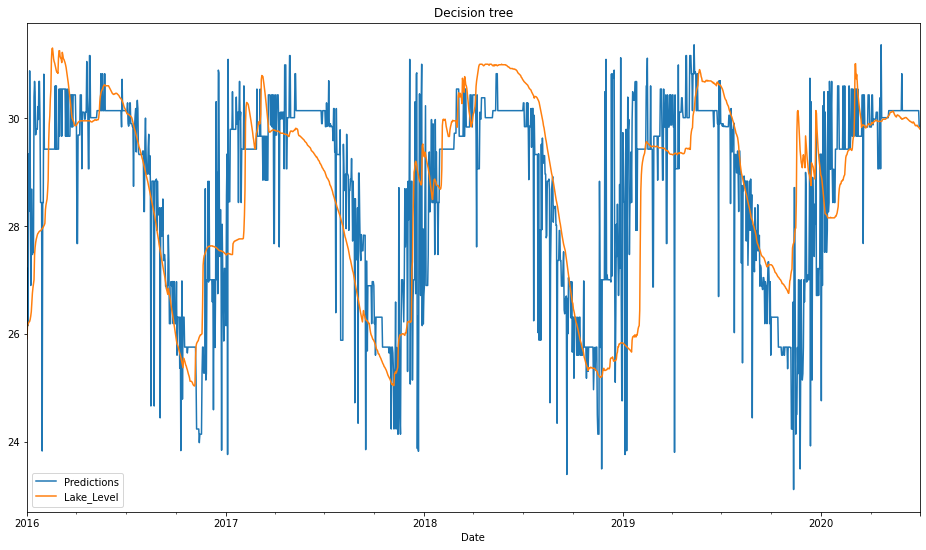

In [16]:
dtr = tree.DecisionTreeRegressor(max_depth=10)

dtr_result = run_model(dtr, lrn_input, lrn_output, tgt_input, tgt_output)

evaluate_ae(dtr_result)

# graph = Source(tree.export_graphviz(dtr, out_file=None, feature_names=lrn_input.columns, filled = True))
# display(SVG(graph.pipe(format='svg')))

dtr_result.plot(title='Decision tree', figsize=(16, 9))

In [17]:
lrn_input

,Temperature_Le_Croci,weekOfYear_cos,weekOfYear_sin
Date,,,
2004-01-02,0.191176,1.000000,0.000000
2004-01-03,0.130882,1.000000,0.000000
2004-01-04,0.058824,1.000000,0.000000
2004-01-05,0.026471,0.992981,0.118273
2004-01-06,0.066176,0.992981,0.118273
...,...,...,...
2015-12-27,0.145588,0.972023,-0.234886
2015-12-28,0.102941,0.992981,-0.118273
2015-12-29,0.185294,0.992981,-0.118273


/Users/klemenkozelj/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/klemenkozelj/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


   MAE: 0.7583313451004258
   RMAE: 1.075956907072428
Adding rolling average over results:
   MAE: 0.7022318237454096
   RMAE: 0.9629482504793143


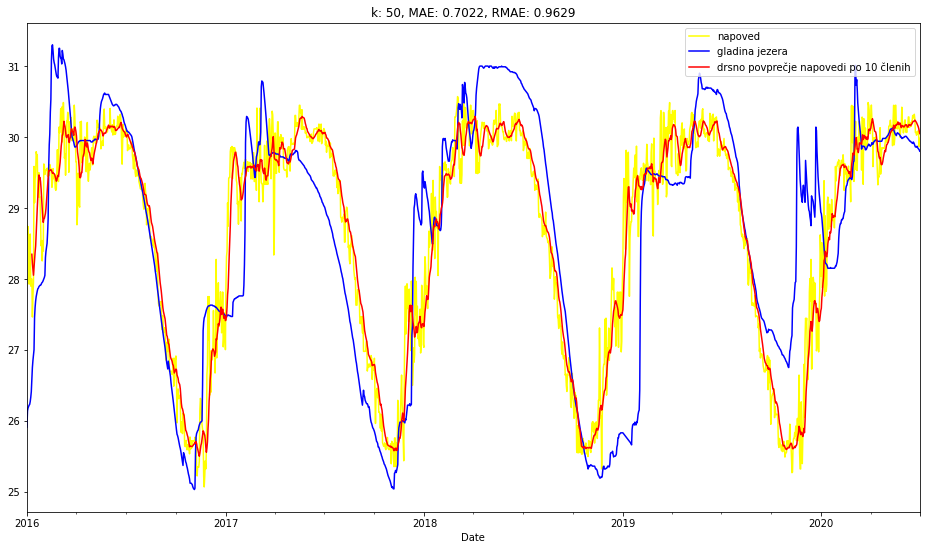

In [18]:
# Observation bigger the K smoother the line
k = 50
r = 10
knr = KNeighborsRegressor(n_neighbors=k)

knr_result = run_model(knr, lrn_input, lrn_output, tgt_input, tgt_output)
evaluate_ae(knr_result)

print('Adding rolling average over results:')
knr_result['Predictions2'] = knr_result['Predictions'].rolling(r).mean()
mae, rmae = evaluate_ae(knr_result, 'Predictions2')

knr_result.rename(columns={
    'Predictions': 'napoved',
    'Predictions2': 'drsno povprečje napovedi po {} členih'.format(r),
    'Lake_Level': 'gladina jezera'
}).plot(
    title='k: {}, MAE: {}, RMAE: {}'.format(k, round(mae, 4), round(rmae, 4)),
    figsize=(16, 9),
    color=['yellow', 'blue', 'red'],
    alpha=1.0,
);

In [19]:
df_bench = pd.read_csv('./data/model_benchmark.csv', sep=',', header=0, index_col=1)
df_bench = df_bench.drop(['Unnamed: 0', 'past'], axis=1)
df_bench.head(5)

,mae,rmae,Δ mea
future,,,
1.0,0.045494,0.010861,NaN
2.0,0.066270,0.021829,0.020776
3.0,0.084400,0.033841,0.018130
4.0,0.105736,0.051493,0.021336
5.0,0.121613,0.062717,0.015877


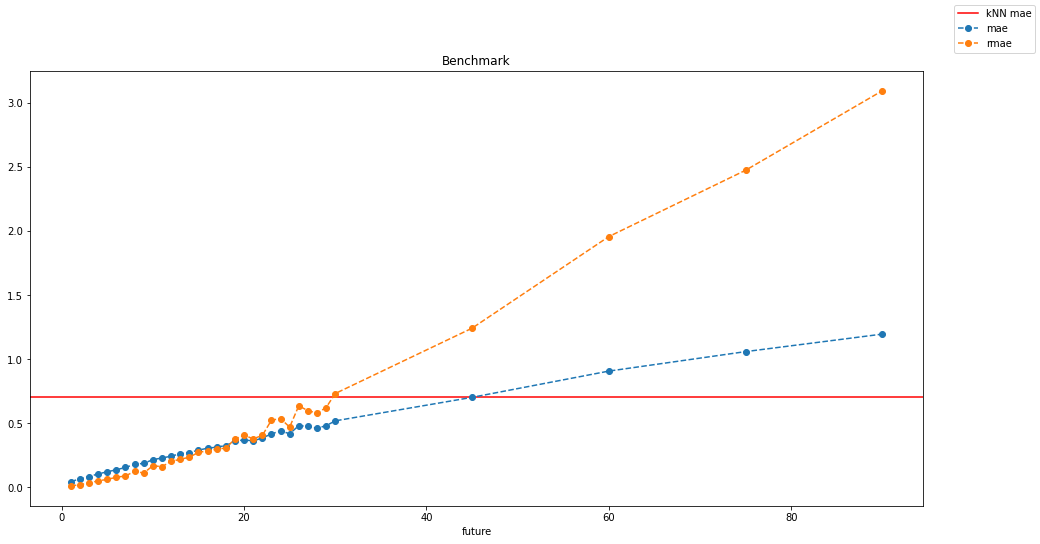

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plt.axhline(y=mae, color='r', linestyle='-', label='kNN mae')
df_bench[['mae', 'rmae']].plot(title='Benchmark', linestyle='--', marker='o', ax=ax, legend=False);

fig.legend()

# Sentinel 2 Satalite Images

In [21]:
from SentinelHubUtils import get_eopatch, delete_frame_eopatch, band_names
from WaterMaskUtils import get_water_mask, visualise_water_mask
from WaterUtils import myNDWI_index

In [22]:
lake_Bilanino_dir = './data/02_EO_Lake_Bilancino'

time_interval = ('2015-01-01', '2021-01-01') # Sentinel 2 program was launched in 2015
geoPointBotLeft=(43.97045396264973, 11.235303869212837) # whole lake with surrounding area
geoPointTopRight=(43.99936511447475, 11.291311279872092)
roi_bbox=(geoPointBotLeft, geoPointTopRight)

eopatch = get_eopatch(lake_Bilanino_dir, roi_bbox, time_interval)
eopatch

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(71, 333, 440, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(71, 333, 440, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(71, 333, 440, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(71, 333, 440, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(71, 333, 440, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(71, 333, 440, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(71, 333, 440, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(71, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 440
    size_y: 333
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2021-01-01T23:59:59')
  }
  bbox: BBox(((11.235303869212837, 43.97045396264973), (11.291311279872092, 43.99936511447475)), crs=C

In [23]:
delete_frame_eopatch(eopatch, 61) #it is cloudy and unaccurate

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(70, 333, 440, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(70, 333, 440, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(70, 333, 440, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(70, 333, 440, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(70, 333, 440, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(70, 333, 440, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(70, 333, 440, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(70, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 440
    size_y: 333
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2021-01-01T23:59:59')
  }
  bbox: BBox(((11.235303869212837, 43.97045396264973), (11.291311279872092, 43.99936511447475)), crs=C

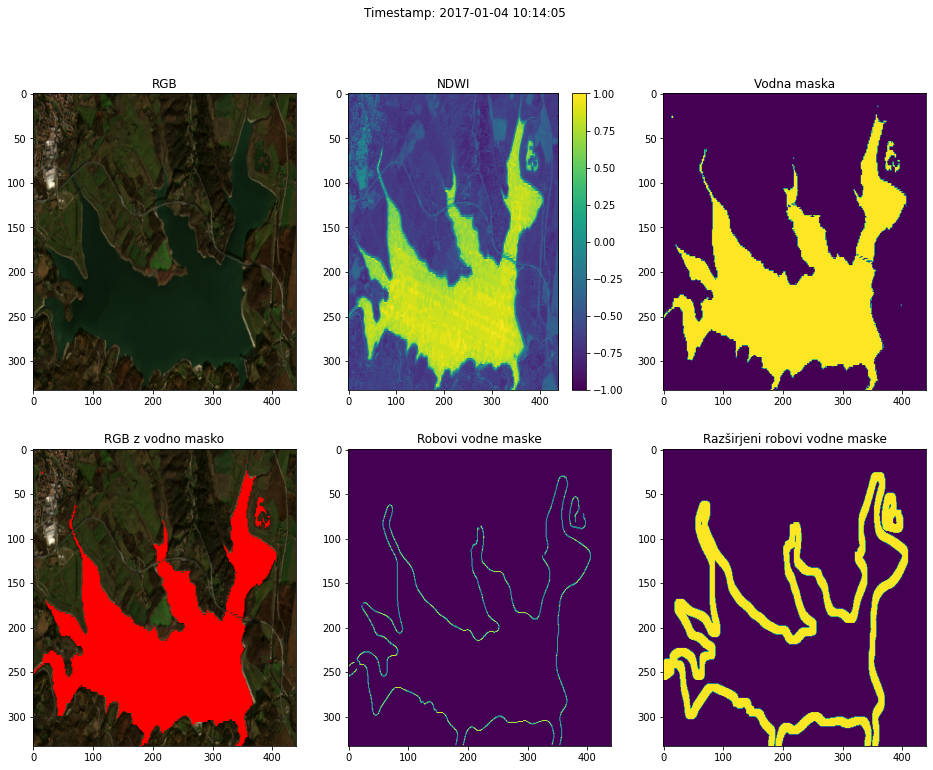

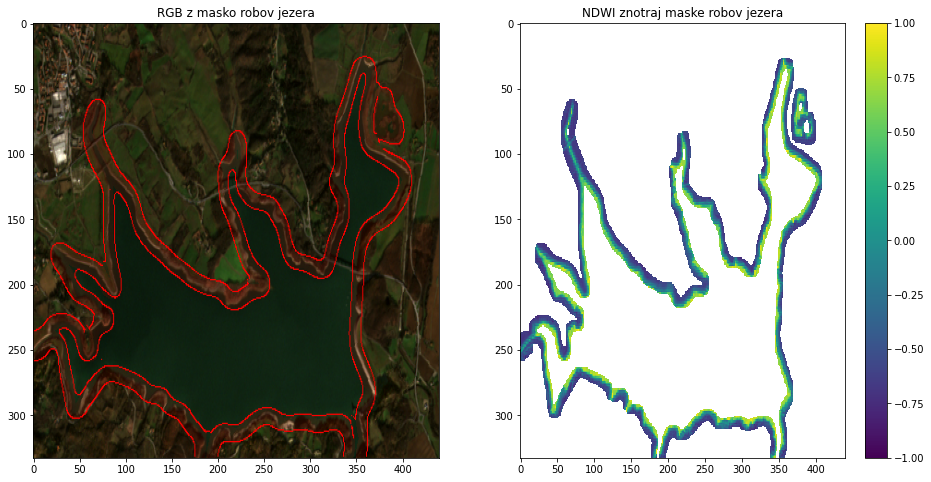

In [24]:
(water_mask, water_edges, shores, shores_edges) = get_water_mask(
    eopatch,
    water_treshhold=0.4,
    canny_sigma=5,
    gauss_sigma=1
)
index = 1
visualise_water_mask(band_names, eopatch, index, water_mask, water_edges, shores, shores_edges)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

rgb = np.clip(eopatch.data['BANDS'][index][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)

rgb[shores_edges] = (1, 0, 0)
ax[0].imshow(rgb, aspect='auto')
rgb[shores] = (1, 0, 0)
ax[0].imshow(rgb, aspect='auto', alpha=0.1)
ax[0].set_title('RGB z masko robov jezera')

NDWI_AoI = np.copy(eopatch.data['NDWI'][index].squeeze())
NDWI_AoI[~shores] = float('nan')

ax[1].set_title('NDWI znotraj maske robov jezera')
pos = ax[1].imshow(NDWI_AoI, aspect='auto', vmin=-1, vmax=1)
fig.colorbar(pos, ax=ax[1])

In [25]:
def myNDWI_index(eopatch, mask, NDWI_threshold=0.2):

    NDWI = np.copy(eopatch.data['NDWI'].squeeze())
    NDWI[:, ~mask] = float('nan')
    NDWI[~eopatch.mask['VALID_DATA'].squeeze()] = float('nan')
    NDWI = NDWI >= NDWI_threshold
        
    eo = pd.DataFrame({
        'Date': eopatch.timestamp,
        'NDWI': np.nanmean(NDWI.reshape(len(NDWI), -1), axis=1),
    })

    eo['Date'] = pd.to_datetime(eo['Date']).dt.date
    eo = eo.set_index('Date')
    
    return eo, NDWI

# first model was all average so comment out all masks -0.36%

# used_mask = water_mask #= 80%
# eo, NDWI = myNDWI_index(eopatch, used_mask, 0.0)

used_mask = shores # 86%
eo, NDWI = myNDWI_index(eopatch, used_mask, -0.025)

In [26]:
NDVI = np.copy(eopatch.data['NDVI'].squeeze())
NDVI[:, water_mask] = float('nan')
NDVI_threshold = 0.25
NDVI = NDVI >= NDVI_threshold
eo['NDVI'] = np.nanmean(NDVI.reshape(len(NDVI), -1), axis=1)

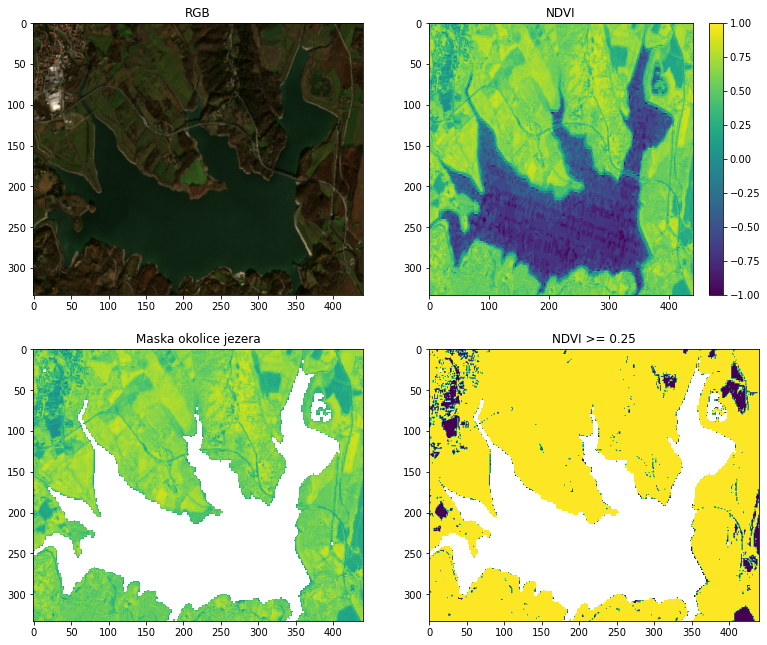

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(13, 11))

rgb = np.clip(eopatch.data['BANDS'][index][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)

ax[0][0].imshow(rgb, aspect='auto')
ax[0][0].set_title('RGB')

NDVI_AoI = np.copy(eopatch.data['NDVI'][index].squeeze())

ax[0][1].set_title('NDVI')
pos = ax[0][1].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
fig.colorbar(pos, ax=ax[0][1])


NDVI_AoI[water_mask] = float('NaN')
ax[1][0].set_title('Maska okolice jezera')
pos = ax[1][0].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
# fig.colorbar(pos, ax=ax[1][0])

NDVI_AoI[NDVI_AoI >= NDVI_threshold] = 1
NDVI_AoI[NDVI_AoI < NDVI_threshold] = -1
NDVI_AoI[water_mask] = float('NaN')

ax[1][1].set_title('NDVI >= 0.25')
pos = ax[1][1].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
# fig.colorbar(pos, ax=ax[1][1])

# fig, ax = plt.subplots(1, 4, figsize=(16, 5))

# rgb = np.clip(eopatch.data['BANDS'][index][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)

# ax[0].imshow(rgb, aspect='auto')
# ax[0].set_title('RGB')

# NDVI_AoI = np.copy(eopatch.data['NDVI'][index].squeeze())

# ax[1].set_title('NDVI')
# pos = ax[1].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
# # fig.colorbar(pos, ax=ax[1])

# NDVI_AoI[water_mask] = float('NaN')
# ax[2].set_title('Maska okolice jezera')
# pos = ax[2].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
# # fig.colorbar(pos, ax=ax[1][0])

# NDVI_AoI[NDVI_AoI >= NDVI_threshold] = 1
# NDVI_AoI[NDVI_AoI < NDVI_threshold] = -1
# NDVI_AoI[water_mask] = float('NaN')

# ax[3].set_title('NDVI >= 0.25')
# pos = ax[3].imshow(NDVI_AoI, aspect='auto', vmin=-1, vmax=1)
# fig.colorbar(pos, ax=ax[3])

Lake_Level    1323
NDWI            70
NDVI            70
dtype: int64


,Lake_Level,NDWI,NDVI
Lake_Level,1.000000,0.864758,0.451729
NDWI,0.864758,1.000000,0.196398
NDVI,0.451729,0.196398,1.000000


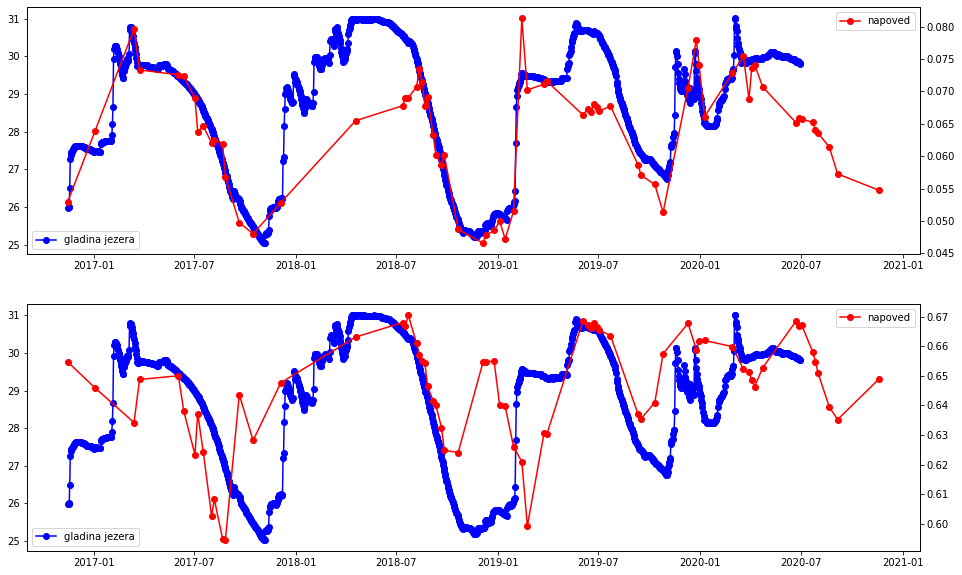

In [28]:
real_values=df.loc[df.index >= min(eopatch.timestamp), ['Lake_Level']] # Flow_Rate could be added here

merged = real_values.join(eo, how='outer')

NDWI_line = merged['NDWI'][np.isfinite(merged['NDWI'])] # not interpolation it leaves NaN just for visualisation
NDVI_line = merged['NDVI'][np.isfinite(merged['NDVI'])]

fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(merged['Lake_Level'], color='blue', linestyle='-', marker='o', label='gladina jezera')
ax0twinx = ax[0].twinx()
ax0twinx.plot(NDWI_line, color='red', linestyle='-', marker='o', label='napoved')
ax[0].legend(loc=3)
ax0twinx.legend(loc=1)

ax[1].plot(merged['Lake_Level'], color='blue', linestyle='-', marker='o', label='gladina jezera')
ax1twinx = ax[1].twinx()
ax1twinx.plot(NDVI_line, color='red', linestyle='-', marker='o', label='napoved')
ax[1].legend(loc=3)
ax1twinx.legend(loc=1)

print(merged.count())

merged.corr(method='pearson')

In [29]:
# matplotlib.rcParams['animation.embed_limit'] = 2**128

# mereged_ani = merged.dropna()

# fig = plt.figure(figsize=(16, 10), constrained_layout=True)
# gs = fig.add_gridspec(2, 6, height_ratios=[1, 3])
# ax_top = fig.add_subplot(gs[0, :])
# ax_lef = fig.add_subplot(gs[1, 0:2])
# ax_mid = fig.add_subplot(gs[1, 2:4])
# ax_rig = fig.add_subplot(gs[1, 4:6])

# ax_top.axis((mereged_ani.index[0], mereged_ani.index[-1], mereged_ani['Lake_Level'].min(), mereged_ani['Lake_Level'].max()))
# ax_top2 = ax_top.twinx()
# ax_top2.axis((mereged_ani.index[0], mereged_ani.index[-1], mereged_ani['NDWI'].min(), mereged_ani['NDWI'].max()))

# rgbs = np.clip(eopatch.data['BANDS'][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)
# rgbs[:, shores_edges] = (1, 0, 0)
# ndwis = np.copy(eopatch.data['NDWI']).squeeze()
# ndwis[:, shores_edges] = float('nan')

# l1, = ax_top.plot(mereged_ani.index[:0], mereged_ani['Lake_Level'][:0], color='blue', linestyle='-', marker='o', label='Lake_Level')
# l2, = ax_top2.plot(mereged_ani.index[:0], mereged_ani['NDWI'][:0], color='red', linestyle='-', marker='o', label='NDWI')
# l3 = ax_lef.imshow(rgbs[0], vmin=0,  vmax=1, aspect='auto')
# l4 = ax_mid.imshow(ndwis[0], vmin=-1, vmax=1, aspect='auto')
# l5 = ax_rig.imshow(NDWI[0], vmin=0, vmax=1, aspect='auto')

# def animate(i):
#     print('Processing frame: {}/{}'.format(i+1, len(mereged_ani.index)), end='\r')
#     ax_top.set_title('Timeline {}'.format(mereged_ani.index[i]))
#     l1.set_data(mereged_ani.index[:i+1], mereged_ani['Lake_Level'][:i+1])
#     l2.set_data(mereged_ani.index[:i+1], mereged_ani['NDWI'][:i+1])
#     l3.set_data(rgbs[i])
#     ax_lef.set_title('RGB')
#     l4.set_data(ndwis[i])
#     ax_mid.set_title('NDWI')
#     l5.set_data(NDWI[i])
#     ax_rig.set_title('Algoritem {:.4f}'.format(mereged_ani['NDWI'][i]))
    
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(mereged_ani.index))

# HTML(ani.to_jshtml())

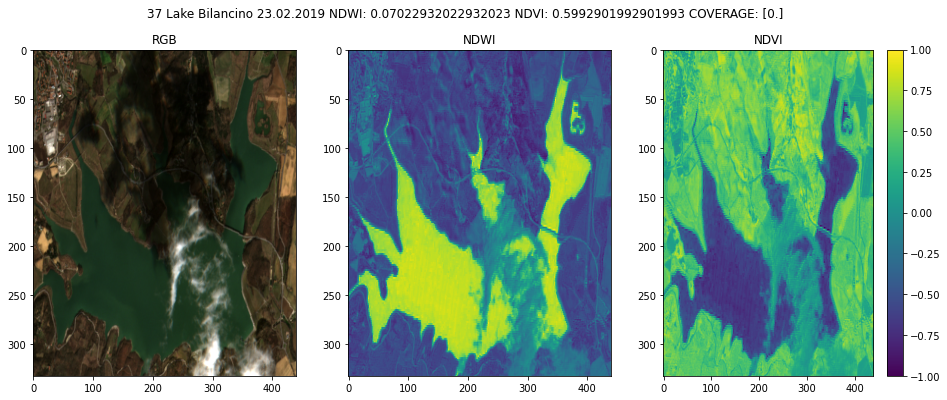

In [30]:
def visualise_lake(image_i):
    fig, axarr = plt.subplots(1, 3, figsize=(16, 6))

    suptitle = '{} Lake Bilancino {} NDWI: {} NDVI: {} COVERAGE: {}'.format(
        str(image_i),
        eopatch.timestamp[image_i].strftime('%d.%m.%Y'),
        str(eo['NDWI'][image_i]),
        str(eo['NDVI'][image_i]),
        str(eopatch.scalar['COVERAGE'][image_i])
    )
    
    fig.suptitle(suptitle)

    rgb=np.clip(eopatch.data['BANDS'][image_i][..., [band_names.index('B04'),band_names.index('B03'),band_names.index('B02')]] * 3, a_min=0, a_max=1)
    axarr[0].imshow(rgb, vmin=0, vmax=1, aspect='auto')
    axarr[0].set_title('RGB')
    
    pos = axarr[1].imshow(eopatch.data['NDWI'][image_i].squeeze(), aspect='auto', vmin=-1, vmax=1)
    axarr[1].set_title('NDWI')
    
    pos3 = axarr[2].imshow(eopatch.data['NDVI'][image_i].squeeze(), aspect='auto', vmin=-1, vmax=1)
    fig.colorbar(pos3, ax=axarr[2])
    axarr[2].set_title('NDVI')

# visualise_lake(eo['NDWI'].argmin())
# visualise_lake(eo['NDWI'].argmax())

# Two cloudy scenes
# visualise_lake(61)
# visualise_lake(52)
visualise_lake(37)

(63, 5)
   MAE: 0.4701587301587275
   RMAE: 0.32720634920634634
(1324,)
Date
2020-06-30    29.8
Name: Lake_Level, dtype: float64


<AxesSubplot:xlabel='Date'>

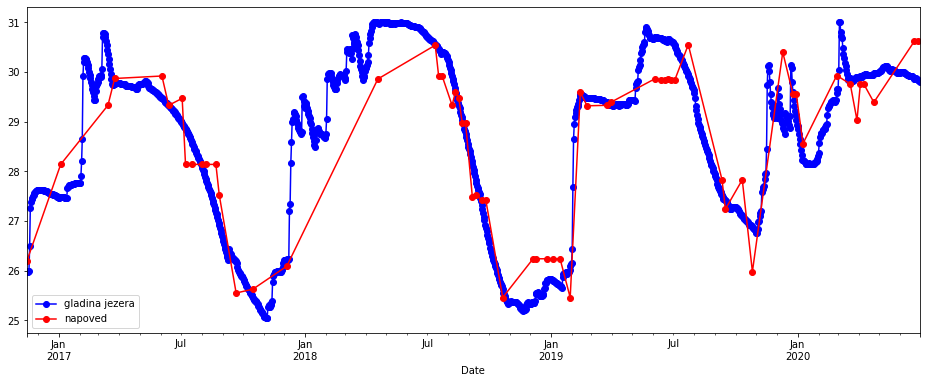

In [31]:
df2 = merged.drop(['Lake_Level'], axis=1) 
df2 = df2.join(df, how='outer')

df2 = df2.drop(['Flow_Rate', 'Temperature_Le_Croci'], axis=1)
df2 = df2[df2.index >= df2['NDWI'].dropna().index[0]] # rows before first NDWI (satelite) row
df2 = df2.dropna() # drop rows without Lake_Level

print(df2.shape)
kf = KFold(n_splits=5) # Kfold works well with time because it keeps the intervals

all_results = pd.DataFrame()

# graph = Source(tree.export_graphviz(dtr, out_file=None, feature_names=lrn_input.columns, filled = True))
# display(SVG(graph.pipe(format='svg')))
# dtr_result.plot(title='Decision tree', figsize=(16, 9))

for train_index, test_index in kf.split(df2):
    learn = df2.iloc[train_index]
    test = df2.iloc[test_index]
    dtr = tree.DecisionTreeRegressor(max_depth=10)
    
    result = run_model(
        dtr,
        learn.drop(['Lake_Level'], axis=1),
        learn['Lake_Level'],
        test.drop(['Lake_Level'], axis=1),
        test['Lake_Level'],
    )
    
    all_results = all_results.append(result)

evaluate_ae(all_results)


fig, ax = plt.subplots(1, 1, figsize=(16, 6))

print(df.loc[df.index >= all_results.index.min(), 'Lake_Level'].shape)
print(df.loc[df.index >= all_results.index.min(), 'Lake_Level'].tail(1))

df.loc[df.index >= all_results.index.min(), 'Lake_Level'].plot(
    linestyle='-',
    marker='o',
    ax=ax,
    color='blue',
    label='gladina jezera',
    legend=True,
    #alpha=0.3
)


all_results['Predictions'].plot(
    linestyle='-',
    marker='o',
    color=['red'],
    ax=ax,
    label='napoved',
    legend=True
)

# all_results.rename(
#     columns={
#         "Lake_Level": "gladina jezera (napovedovani dan)",
#         "Predictions": "napoved"
#     }
# ).plot(linestyle='-', marker='o', color=['red', 'blue'], ax=ax)